
# BLU14 - Exercise Notebook


In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import category_encoders
import json
import joblib
import pickle
import math
import requests
from copy import deepcopy
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

After the police you nailed another big client. A hospital hired you to try to help predicting if a person is going to suffer from heart disease or not, so they can redirect patients from other appointments into the proper treatment, if needed, minimizing later problems with this. You're no expert in the medical field, but you decide to take on the challenge.

<img src="media/helth.png" width=400 />

They provide you with a dataset with several patient measures and the fact that they had heart disease or not.

They also provide you with the following data description:

#### Attribute Information

    1) age
    2) sex
    3) cp - chest pain type (4 values)
    4) trestbps - resting blood pressure
    5) chol - serum cholesterol in mg/dl
    6) fbs - fasting blood sugar > 120 mg/dl
    7) restecg - resting electrocardiographic results (values 0,1,2)
    8) thalach - maximum heart rate achieved
    9) exang - exercise induced angina
    10) oldpeak - ST depression induced by exercise relative to rest
    11) slope - the slope of the peak exercise ST segment
    12) ca - number of major vessels (0-3) colored by fluoroscopy
    13) thal - thallium stress test: 0 = normal; 1 = fixed defect; 2 = reversable defect
    14) target - 0= less chance of heart attack 1= more chance of heart attack

**Note**: even if the dataset has values outside of the data dictionary, you should for these exercises consider the data dictionary as the source truth

Load the dataset below and check out its format:


In [2]:
df = pd.read_csv(os.path.join("data", "heart.csv"))
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Let's split our data into train and test:

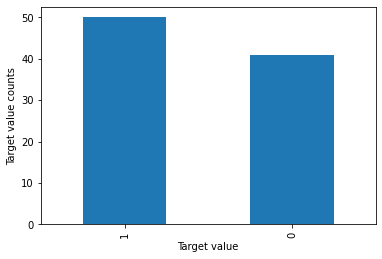

In [3]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

df_test.target.value_counts().plot(kind="bar");
plt.xlabel('Target value');
plt.ylabel('Target value counts');


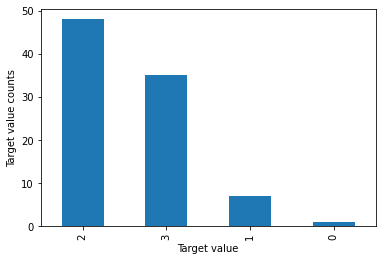

In [4]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

df_test.thal.value_counts().plot(kind="bar");
plt.xlabel('Target value');
plt.ylabel('Target value counts');



### Q1)  

### Q1.a) Train a baseline model

Build a baseline model for this problem (don't worry about performance for now) and serialize it. Use the following features:

    1) age
    2) sex
    3) cp - chest pain type (4 values)
    4) trestbps - resting blood pressure
    6) fbs - fasting blood sugar > 120 mg/dl
    7) restecg - resting electrocardiographic results (values 0,1,2)
    10) oldpeak - ST depression induced by exercise relative to rest
    12) ca - number of major vessels (0-3) colored by fluoroscopy
    13) thal - thallium stress test: 0 = normal; 1 = fixed defect; 2 = reversable defect


**Note**: As we already provided the split, use the `df_train` to train your model.

In [5]:
# This is a temporary directory where your serialized files will be saved. Make sure you use this as 
# the target folder when you serialize your files
TMP_DIR = '/tmp'

In [6]:
# Write code to train and serialize a model in the block below
#
# Outputs expected: `columns.json`, `dtypes.pickle` and `pipeline.pickle`
#
# Your pipeline should be able to receive a dataframe with the columns we've requested you to use
# in the form `pipeline.predict(test_df)`
#

# YOUR CODE HERE
known_categories = {
    "sex": {"values": ["0", "1"], "default": None},
    "cp": {"values": ["0", "1", "2", "3"], "default": None},
    "restecg": {"values": ["0", "1", "2"], "default": None},
    "ca": {"values": ["0", "1", "2", "3","4"], "default": None},
    "thal": {"values": ["0", "1", "2","3"], "default": "0"}
}

def resolve_unexpected(df, known_categories):
    processed_df = df.copy()
    defaults = 0
    dropped = 0
    
    for column in known_categories.keys():
        mapping = known_categories[column]
        bad_rows = processed_df[~processed_df[column].isin(mapping.get('values'))].index
        if bad_rows.empty:
            continue
        if mapping.get('default'):
            processed_df.iloc[bad_rows, df.columns.get_loc(column)] = mapping.get('default')
            defaults += len(bad_rows)
        else:
            processed_df.drop(bad_rows, inplace=True)
            dropped += len(bad_rows)
            
    return processed_df, defaults, dropped
        

df_train, defaults, dropped = resolve_unexpected(df_train, known_categories)

df_test, defaults, dropped = resolve_unexpected(df_test, known_categories)
   
target = 'target'
all_features = [
  'age',
  'sex',
  'cp',
  'trestbps', 
  'fbs',
  'restecg',
  'oldpeak',
  'ca',
  'thal'
]

numerical_features = ['age',
                      'trestbps',
                      'fbs',
                      'oldpeak']
categorical_features = [
  'sex',
  'cp',
  'restecg',
  'ca',
  'thal'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1),
)


X_train = df_train[all_features]
y_train = df_train[target]

pipeline.fit(X_train, y_train)

X_test = df_test[all_features]
y_test = df_test[target]

y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# To use on other cells
X_train_baseline = X_train.copy()
X_test_baseline = df_test.copy()
y_test_baseline = X_test_baseline[target].copy()
y_pred_baseline = y_pred.copy()
pipeline_baseline = pipeline


with open(os.path.join(TMP_DIR, 'columns.json'), 'w') as fh:
    json.dump(X_train_baseline.columns.tolist(), fh)
    
with open(os.path.join(TMP_DIR,'dtypes.pickle'), 'wb') as fh:
    pickle.dump(X_train_baseline.dtypes, fh)

    
with open(os.path.join(TMP_DIR,'pipeline.pickle'), 'wb') as fh:
    pickle.dump(pipeline, fh)



Test your procedure is correct by running the asserts below:

In [7]:
with open(os.path.join(TMP_DIR, 'columns.json')) as fh:
    columns = json.load(fh)
    assert columns == ["age", "sex", "cp", "trestbps", "fbs", "restecg", "oldpeak", "ca", "thal"]

with open(os.path.join(TMP_DIR, 'dtypes.pickle'), 'rb') as fh:
    dtypes = pickle.load(fh)
    assert dtypes.apply(lambda x: str(x)).isin(["int64", "int32", "float64", "float32"]).all()

with open(os.path.join(TMP_DIR, 'pipeline.pickle'), 'rb') as fh:
    pipeline = joblib.load(fh)
    assert isinstance(pipeline, Pipeline)
    assert pipeline.predict(pd.DataFrame([{
        "age": 23, 
        "sex": 1, 
        "cp": 3, 
        "trestbps": 120, 
        "fbs": 1,
        "restecg": 1,
        "oldpeak": 0, 
        "ca": 0, 
        "thal": 1}
    ], columns=columns).astype(dtypes)) in [0, 1]

### Q1.b) Client requirements


Now, the doctors asked you one more thing. They want to make sure your model is as good at retrieving male cases of heart disease as it is retrieving female cases. 

For example, if we have a pool of patients where 100 male patients actually have heart disesase and we retrieve 80 out of those, and where 100 female patients also have heart disesase but we only return 20 from those, then you're discrimating and that's not ok. A similar proportion, such as 75 women out of the 100 with heart disease, is expected.

Build a small function to verify this. In particular make sure that the difference in percentage points is not higher than 5:

In [8]:
def verify_retrieve_rates(X_test, y_true, y_test):
    """
    Verify retrieval rates for different `sex` instances are 
    not different by more than 5 percentage points
    
    Inputs:
        X_test: features for the test cases
        y_true: true labels for the test cases [0, 1]
        y_test: predictions for the test cases [0, 1]

    Returns: tuple of (success, rate_difference)
        success: True if the condition is satisfied, otherwise False
        rate_difference: difference between each class retrieval rates (as an absolute value) 
        
    """
    # YOUR CODE HERE
    
    sensitive_classes = X_test['sex'].unique()
    
    is_satisfied = True
    
    precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test['sex'] == sensitive_class)
        if mask.sum():
            precisions[sensitive_class] = recall_score(y_true[mask], y_pred[mask], pos_label=1)
                
    rate_difference = np.max(list(precisions.values())) - np.min(list(precisions.values()))
    
    if rate_difference > 0.05:
            success = False
    else:
        success = True
    
    return success, rate_difference



Verify your function is working on a couple of models

In [9]:

model_1 = pd.read_csv(os.path.join('data', 'data_model_1.csv'))

X_test = model_1.copy().drop(columns=['target', 'prediction'])
y_test = model_1.target
y_pred = model_1.prediction

success, rate_diff = verify_retrieve_rates(X_test, y_test, y_pred) 
assert success is False
assert math.isclose(rate_diff, 0.20138888888888884)

model_2 = pd.read_csv(os.path.join('data', 'data_model_2.csv'))

X_test = model_2.copy().drop(columns=['target', 'prediction'])
y_test = model_2.target
y_pred = model_2.prediction

success, rate_diff = verify_retrieve_rates(X_test, y_test, y_pred) 
assert success is True
assert math.isclose(rate_diff, 0.04513888888888884)


If you passed the asserts, you've defused this task. Move forward to the next one 

<img src="media/client-specs.png" width=400 />




<br>

### Q2) Prepare the model to be served


Now use the model that you built for Q1 and build a predict function around it that will parse the request and return the respective prediction. Split your code into initialization and prediction code as you've learned. Additionally, instead of returning 0 or 1, return True or False. Do not worry about potential bad inputs at this point, we'll get to it later on.



In [10]:
# Initialization code

# YOUR CODE HERE

def predict(request):
    """
    Produce prediction for request.
    
    Inputs:
        request: dictionary with format described below
        
        ```
        {
            "observation_id": <id-as-a-string>,
            "data": {
                "age": <value>,
                "sex": "0",
                "cp": <value>,
                "trestbps": <value>,
                "fbs": <value>,
                "restecg": <value>,
                "oldpeak": <value>,
                "ca": <value>,
                "thal": <value>
            }
        }
        ```
    
    Returns:
        response: A dictionary echoing the request and its data with the addition of the prediction and probability 
            ```
            {
                "observation_id": <id-of-request>,
                "age": <value-of-request>,
                "sex": <value-of-request>,
                "cp": <value-of-request>,
                "trestbps": <value-of-request>,
                "fbs": <value-of-request>,
                "restecg": <value-of-request>,
                "oldpeak": <value-of-request>,
                "ca": <value-of-request>,
                "thal": <value-of-request>,
                "prediction": <True|False>,
                "probability": <probability generated by model>
            }
            ```
    """
    # YOUR CODE HERE

    observation = request

    url="http://127.0.0.1:5000/predict"
    headers = {'Content-Type': 'application/json'}

    r = requests.post(url, data=json.dumps(observation), headers=headers)

    r=json.loads(r.text) 

    response = request.copy()
    del response['data']
    
    response.update(request['data'])
    
    response.update(r)
   # del response['error']

    return response

Test your function on the code below:

In [11]:

request = {
    "observation_id": "1",
    "data": 
        {
            "age": 23, 
            "sex": 1, 
            "cp": 3, 
            "trestbps": 120, 
            "fbs": 1, 
            "restecg": 1, 
            "oldpeak": 0, 
            "ca": 0, 
            "thal": 1
        }
}

response = predict(request)
assert sorted(response.keys()) == \
    sorted(["observation_id", "age", "sex", "cp", "trestbps", "fbs", "restecg", 
            "oldpeak", "ca", "thal", "prediction", "probability"])

assert response["observation_id"] == "1"
assert response["age"] == 23
assert response["restecg"] == 1
assert response["prediction"] in [True, False]

probability_1 = response["probability"] 


request = {
    "observation_id": "2",
    "data": 
        {
            "age": 44, 
            "sex": 0, 
            "cp": 2, 
            "trestbps": 170, 
            "fbs": 1, 
            "restecg": 1, 
            "oldpeak": 1, 
            "ca": 0, 
            "thal": 2
        }
}

response = predict(request)
assert sorted(response.keys()) == \
    sorted(["observation_id", "age", "sex", "cp", "trestbps", "fbs", "restecg", 
            "oldpeak", "ca", "thal", "prediction", "probability"])

assert response["observation_id"] == "2"
assert response["fbs"] == 1
assert response["restecg"] == 1
assert response["prediction"] in [True, False]

probability_2 = response["probability"] 

assert probability_1 != probability_2



Hurray! It passed the tests. 


<br>

### Q3) Make sure your input is correct

Now let's be a bit more thorough

Protect your function against unexpected inputs. Create a function similar to the one before, but 
this time, return a different response. If everything is well with your request return an answer like this:

```json
{
    "observation_id": "id1234",
    "prediction": True,
    "probability": 0.4
}
```

However, if there is a problem with the initial data, whether it's fields missing or invalid values, return a different response:

```json
{
    "observation_id": "id1234",
    "error": "Some error occured",
}
```


#### Hints 

- Hint 1: If the `observation_id` is not present, set it to None
- Hint 2: Check out the tests to see what we expect from the error cases and error messages


In [12]:
# Initialization code

# YOUR CODE HERE
    
def attempt_predict(request):
    """
    Produce prediction for request.
    
    Inputs:
        request: dictionary with format described below
        
        ```
        {
            "observation_id": <id-as-a-string>,
            "data": {
                "age": <value>,
                "sex": <value>,
                "cp": <value>,
                "trestbps": <value>,
                "fbs": <value>,
                "restecg": <value>,
                "oldpeak": <value>,
                "ca": <value>,
                "thal": <value>
            }
        }
        ```
     
    Returns: A dictionary with predictions or an error, the two potential values:
                ```
                {
                    "observation_id": <id-of-request>,
                    "prediction": <True|False>,
                    "probability": <probability generated by model>
                }
                ```
                or 
                ```
                {
                    "observation_id": <id-of-request>,
                    "error": "some error message"
                }
                ```
                if success is False, return an error string
    """

    # YOUR CODE HERE

    #observation_id 
    if "observation_id" not in request:
        response={}
        response['observation_id'] = None
        response['error']= "observation_id"
    
    # doesn't have data
    elif "data" not in request:
        response={}
        response['observation_id'] = request['observation_id']
        response['error']= "data"
    
    # doesn't have age
    
    elif "age" not in request['data']:
        response={}
        response['observation_id'] = request['observation_id']
        response['error']= "age"  
        
        

    # bloodpressure assert 4
    elif "bloodpressure" in request['data']:
        response={}
        response['observation_id'] = request['observation_id']
        response['error']= "bloodpressure" 
    # sex assert 5 
    elif int(request['data']["sex"]) > 2:

        response = {"error": ('sex', '3')}

        
    # Hello world
    
    elif not isinstance(request['data']['ca'] , int):
            response = {"error": ('ca', 'Hello world')}

        
    #age

    elif request['data']['age'] < 0:
            response = {"error": ('age', str(request['data']['age']))}
           
    elif request['data']['age'] >120:
            response = {"error": ('age', str(request['data']['age']))}

            
    # trstbps
    elif request['data']['trestbps'] < 40:
            response = {"error": ('trestbps', str(request['data']['trestbps']))}
            
    elif request['data']['trestbps'] >200:
            response = {"error": ('trestbps', str(request['data']['trestbps']))}

    # oldpeak
    
    elif request['data']['oldpeak'] >10:
            response = {"error": ('oldpeak', str(request['data']['oldpeak']))}

        
        
    elif "data" in request:
        observation = request

        url="http://127.0.0.1:5000/predict"
        headers = {'Content-Type': 'application/json'}

        r = requests.post(url, data=json.dumps(observation), headers=headers)

        r=json.loads(r.text) 
        response={}
        response = request.copy()
        del response['data']

        response.update(r)
      #  del response['error']
         
#    print(response)

    return response

Run the tests below to validate your function is protected against some simple cases:

In [13]:
################################################
# Test with good payload
################################################

base_request = {
    "observation_id": "1",
    "data": 
        {
            "age": 23, 
            "sex": 1, 
            "cp": 3, 
            "trestbps": 120, 
            "fbs": 1, 
            "restecg": 1, 
            "oldpeak": 0.0, 
            "ca": 0, 
            "thal": 1
        }
}

response = attempt_predict(base_request)
assert 'prediction' in response, response
assert 'probability' in response, response
assert 'observation_id' in response, response

assert response["observation_id"] == "1", response["observation_id"]
assert response["prediction"] in [True, False], response["prediction"] 
assert response["probability"] <= 1.0, response["probability"] 
assert response["probability"] >= 0.0, response["probability"] 


################################################
# Test missing `observation_id` produces an error
################################################

bad_request_1 = deepcopy(base_request)
bad_request_1['random_field'] = bad_request_1.pop('observation_id')

response = attempt_predict(bad_request_1)
assert 'error' in response, response
assert 'observation_id' in response['error'] 


################################################
# Test missing `data` produces an error
################################################

bad_request_2 = deepcopy(base_request)
bad_request_2['data_field_name'] = bad_request_2.pop('data')

response = attempt_predict(bad_request_2)
assert 'error' in response, response
assert 'data' in response['error'] 


################################################
# Test missing columns produce an error
################################################

bad_request_3 = deepcopy(base_request)
bad_request_3['data'].pop('age')

response = attempt_predict(bad_request_3)
assert 'error' in response, response
assert 'age' in response['error'], response['error']


################################################
# Test extra columns produce an error
################################################

bad_request_4 = deepcopy(base_request)
bad_request_4['data']['bloodpressure'] = 2

response = attempt_predict(bad_request_4)
assert 'error' in response, response
assert 'bloodpressure' in response['error'], response['error']


Run a couple more tests to make sure your server is bulletproof:

In [14]:

####################################################
# Test invalid values for categorical features - sex
####################################################

bad_request_5 = deepcopy(base_request)
bad_request_5['data']['sex'] = 3

response = attempt_predict(bad_request_5)
assert 'error' in response, response
assert 'sex' in response['error'], response['error']
assert '3' in response['error'], response['error']


###########################################################################
# Test invalid values for categorical features - number of vessels coloured
###########################################################################

bad_request_6 = deepcopy(base_request)
bad_request_6['data']['ca'] = 'Hello world'

response = attempt_predict(bad_request_6)
assert 'error' in response, response
assert 'ca' in response['error'], response['error']
assert 'Hello world' in response['error'], response['error']


####################################################
# Test invalid values for numerical features - age
####################################################

bad_request_7 = deepcopy(base_request)
bad_request_7['data']['age'] = -12

response = attempt_predict(bad_request_7)
assert 'error' in response, response
assert 'age' in response['error'], response['error']
assert '-12' in response['error'], response['error']

bad_request_8 = deepcopy(base_request)
bad_request_8['data']['age'] = 1200

response = attempt_predict(bad_request_8)
assert 'error' in response, response
assert 'age' in response['error'], response['error']
assert '1200' in response['error'], response['error']


####################################################
# Test invalid values for numerical features - trestbps
####################################################

bad_request_9 = deepcopy(base_request)
bad_request_9['data']['trestbps'] = 10

response = attempt_predict(bad_request_9)
assert 'error' in response, response
assert 'trestbps' in response['error'], response['error']
assert '10' in response['error'], response['error']

bad_request_10 = deepcopy(base_request)
bad_request_10['data']['trestbps'] = 500

response = attempt_predict(bad_request_10)
assert 'error' in response, response
assert 'trestbps' in response['error'], response['error']
assert '500' in response['error'], response['error']


####################################################
# Test invalid values for numerical features - oldpeak
####################################################

bad_request_11 = deepcopy(base_request)
bad_request_11['data']['oldpeak'] = 12

response = attempt_predict(bad_request_11)
assert 'error' in response, response
assert 'oldpeak' in response['error'], response['error']
assert '12' in response['error'], response['error']

bad_request_12 = deepcopy(base_request)
bad_request_12['data']['oldpeak'] = 40.312

response = attempt_predict(bad_request_12)
assert 'error' in response, response
assert 'oldpeak' in response['error'], response['error']
assert '40.312' in response['error'], response['error']



Ufff. That was tough. But now your app is a bit safer to deploy! At least from all the cases we could think of.

<img src="media/code-passes-tests.png" width=500 />


<br>

### Q4) Put everything together

Finally, build a server with your model and a predict endpoint protected from all the cases before. Deploy it and set 
the name of your app below:

In [15]:
# Assign the variable APP_NAME to the name of your heroku app
# APP_NAME = ...

# YOUR CODE HERE
APP_NAME = "heroku-model-deploy-rita"



# Testing the predict/update endpoint
url = "https://{}.herokuapp.com/predict".format(APP_NAME)

payload = {
    "observation_id": str(uuid4()),
    "data": 
        {
            "age": 23, 
            "sex": 1, 
            "cp": 3, 
            "trestbps": 120, 
            "fbs": 1, 
            "restecg": 1, 
            "oldpeak": 0.0, 
            "ca": 0, 
            "thal": 1
        }
}

requests.post(url, json=payload)

<Response [200]>


Test that your server is bulletproof:

In [16]:
# Test locally
# url = f"http://localhost:5000/predict"


# Testing the predict/update endpoint
url = "https://{}.herokuapp.com/predict".format(APP_NAME)


################################################
# Test with good payload
################################################

payload = {
    "observation_id": str(uuid4()),
    "data": 
        {
            "age": 23, 
            "sex": 1, 
            "cp": 3, 
            "trestbps": 120, 
            "fbs": 1, 
            "restecg": 1, 
            "oldpeak": 0.0, 
            "ca": 0, 
            "thal": 1
        }
}

r = requests.post(url, json=payload)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'prediction' in response, response
assert 'probability' in response, response

assert response["prediction"] in [True, False]

assert isinstance(response["probability"], float)
assert 0 <= response["probability"] <= 1


################################################
# Test missing `observation_id` produces an error
################################################

bad_payload_1 = deepcopy(payload)
bad_payload_1['random_field'] = bad_payload_1.pop('observation_id')

r = requests.post(url, json=bad_payload_1)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'observation_id' in response['error'], response['error']


################################################
# Test missing `data` produces an error
################################################

bad_payload_2 = deepcopy(payload)
bad_payload_2['observation_id'] = str(uuid4())
bad_payload_2['random_field'] = bad_payload_2.pop('data')

r = requests.post(url, json=bad_payload_2)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'data' in response['error'], response['error']


################################################
# Test missing columns produce an error
################################################

bad_payload_3 = deepcopy(payload)
bad_payload_3['observation_id'] = str(uuid4())
bad_payload_3['data'].pop('age')

r = requests.post(url, json=bad_payload_3)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'age' in response['error'], response['error']


################################################
# Test extra columns produce an error
################################################

bad_payload_4 = deepcopy(payload)
bad_payload_4['observation_id'] = str(uuid4())
bad_payload_4['data']['bloodpressure'] = 100

r = requests.post(url, json=bad_payload_4)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'bloodpressure' in response['error'], response['error']


###########################################################################
# Test invalid values for categorical features - number of vessels coloured
###########################################################################


bad_payload_5 = deepcopy(payload)
bad_payload_5['observation_id'] = str(uuid4())
bad_payload_5['data']['ca'] = 'Hello world'

r = requests.post(url, json=bad_payload_5)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'ca' in response['error'], response['error']
assert 'Hello world' in response['error'], response['error']


####################################################
# Test invalid values for numerical features - age
####################################################

bad_payload_6 = deepcopy(payload)
bad_payload_6['observation_id'] = str(uuid4())
bad_payload_6['data']['age'] = -12

r = requests.post(url, json=bad_payload_6)
assert isinstance(r, requests.Response)
assert r.ok

response = r.json()

assert 'error' in response, response
assert 'age' in response['error'], response['error']
assert '-12' in response['error'], response['error']



And... you're done. You have successfully built a model, assessed if it passed the client requirements, built an app and protected it from crappy input. 

It's time for a well deserved rest, so go ahead and go be a couch potato.

<br>

<img src="media/lays.png" width=400 />

